Part 1/3
Data Normlization
Enriched Company Name, City, Country

In [ ]:
# Author: Birsan Daniel
# Title: Company Entity Resolution 

import re
import pandas as pd
import numpy as np
    
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pycountry
import tldextract
import spacy
from transformers import pipeline

import dask.dataframe as dd

# 1. Imports & Model Initialization
nlp_spacy = spacy.load("en_core_web_sm")


extractor = pipeline(
    "token-classification",
    model="dslim/bert-base-NER",
    aggregation_strategy="simple",
    device=0  # set device=-1 if no GPU
)


stopwords_suffixes = [
    "inc", "inc.", "co", "corp", "corporation", "ltd", "llc", "srl", "gmbh", "ltda", "limited"
]

# 2. Load Data
try:
    df_dask = dd.read_parquet(
        "veridion_entity_resolution_challenge.snappy.parquet").persist()
    df_raw = df_dask.compute()
    print("Using Dask to load large dataset.")
except (FileNotFoundError, ValueError):
    print("Could not load with Dask, falling back to pandas.")
    try:
        df_raw = pd.read_parquet(
            "veridion_entity_resolution_challenge.snappy.parquet")
    except FileNotFoundError:
        print("veridion_entity_resolution_challenge.snappys.parquet not found; creating empty DataFrame.")
        df_raw = pd.DataFrame()

print("Raw DataFrame Loaded:")
print(f"Shape: {df_raw.shape}")

# 3. Helper Functions


def remove_company_suffixes(name: str, suffixes=stopwords_suffixes) -> str:
    if name is None or not isinstance(name, str) or not name.strip():
        return None
    tokens = name.split()
    cleaned_tokens = []
    for t in tokens:
        if t.lower() in suffixes:
            continue
        cleaned_tokens.append(t)
    return " ".join(cleaned_tokens).strip()


def normalize_text(text: str) -> str:
    if text is None or not isinstance(text, str) or not text.strip():
        return None
    out = text.strip().lower()
    out = re.sub(r"\s+", " ", out)
    return out


def normalize_email(email: str) -> str:
    if email is None or not isinstance(email, str):
        return None
    e = email.strip().lower()
    return e if "@" in e else None


def normalize_phone(phone: str) -> str:
    if phone is None or not isinstance(phone, str):
        return None
    p = phone.strip()
    p = re.sub(r"[^\d\+]", "", p)
    return p


def parse_domain_tld(url: str):
    if url is None or not isinstance(url, str) or not url.strip():
        return (None, None)
    extracted = tldextract.extract(url)
    #only the name , no tld, no subdomain
    domain = extracted.domain.strip().lower()
    tld = extracted.suffix.strip().lower()
    if not domain or not tld:
        return (None, None)
    if domain.endswith("."):
        domain = domain[:-1]
    if tld.endswith("."):
        tld = tld[:-1]
    return (domain, tld)


def approximate_country_from_code(code: str) -> str:
    if code is None or not code.strip():
        return None
    up = code.strip().upper()
    cobj = pycountry.countries.get(alpha_2=up)
    if not cobj:
        cobj = pycountry.countries.get(alpha_3=up)
    return cobj.name if cobj else None


def approximate_country_from_tld(tld: str) -> str:
    if tld is None or not tld.strip():
        return None
    if len(tld) == 2:
        return approximate_country_from_code(tld)
    return None


def extract_company_name_spacy(text: str) -> str:
    if text is None or not isinstance(text, str) or not text.strip():
        return None
    doc = nlp_spacy(text)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            return ent.text.strip()
    return None


def extract_activity_transformers(text: str) -> str:
    if text is None or not isinstance(text, str) or not text.strip():
        return None
    results = extractor(text)
    found = []
    for r in results:
        if r['entity_group'] in ['MISC', 'ORG']:
            extracted_word = r['word'].strip().lower()
            found.append(extracted_word)
    if found:
        unique_found = list(set(found))
        return ", ".join(unique_found)
    return None


def get_first_n_words(text: str, n: int = 3) -> str:
    if text is None or not isinstance(text, str) or not text.strip():
        return None
    words = text.strip().split()
    return " ".join(words[:n]) if words else None


# ------------------------------------------------------------------------------
# 4. Check & Create Missing Columns
# ------------------------------------------------------------------------------
needed_cols = [
    # Company Identifiers:
    "company_name", "company_legal_names", "company_commercial_names",

    # Location Data:
    "main_country_code", "main_country", "main_region", "main_city_district", "main_city", "main_postcode", "main_street", "main_street_number", "main_latitude", "main_longitude", "main_address_raw_text", "locations",

    # Contact Information:
    "primary_phone", "phone_numbers", "primary_email", "emails", "other_emails",

    # Web Presence:
    "website_url", "website_domain", "website_tld", "website_language_code", "facebook_url", "twitter_url", "instagram_url", "linkedin_url", "ios_app_url", "android_app_url", "youtube_url", "tiktok_url",

    # Business Details:
    "company_type", "year_founded", "lnk_year_founded", "short_description", "long_description", "business_tags", "business_model", "product_type",

    # Industry Codes & Categories:
    "naics_vertical", "naics_2022_primary_code", "naics_2022_primary_label", "naics_2022_secondary_codes", "naics_2022_secondary_labels", "main_business_category", "main_industry", "main_sector",

    # Other Data:
    "sics_codified_industry", "sic_codes", "sic_labels", "isic_v4_codes", "isic_v4_labels", "nace_rev2_codes", "nace_rev2_labels", "created_at", "last_updated_at", "website_number_of_pages", "generated_description", "generated_business_tags", "status", "domains", "all_domains", "revenue", "revenue_type", "employee_count", "employee_count_type", "inbound_links_count"
]

for col in needed_cols:
    if col not in df_raw.columns:
        df_raw[col] = None


# 5. Company Name Enrichment


def best_company_name(row: dict) -> str:
    web = row.get("website_url")
    # handle pd.NA by converting to None if it's a float or pd.NA
    if isinstance(web, float) or pd.isna(web):
        web = None

    domain = None
    if web:
        d, s = parse_domain_tld(web)
        domain = d

    if domain:
        name_candidate = normalize_text(domain)
        return remove_company_suffixes(name_candidate)

    for desc_col in ["short_description", "long_description", "generated_description"]:
        desc_val = row.get(desc_col)
        if isinstance(desc_val, float) or pd.isna(desc_val):
            desc_val = None
        if desc_val:
            first3 = get_first_n_words(desc_val, 3)
            first3 = normalize_text(first3)
            if first3:
                return remove_company_suffixes(first3)

    name_candidates = [
        row.get("company_name"),
        row.get("company_legal_names"),
        row.get("company_commercial_names"),
    ]
    for candidate in name_candidates:
        if isinstance(candidate, float) or pd.isna(candidate):
            candidate = None
        candidate_norm = normalize_text(candidate)
        if candidate_norm:
            return remove_company_suffixes(candidate_norm)

    # spaCy fallback
    for desc_col in ["short_description", "long_description", "generated_description"]:
        desc_val = row.get(desc_col)
        if isinstance(desc_val, float) or pd.isna(desc_val):
            desc_val = None
        ner_name = extract_company_name_spacy(desc_val)
        if ner_name:
            final = normalize_text(ner_name)
            return remove_company_suffixes(final)

    return None

# 6. Location Enrichment (Offline)
# external geocoding will need more time :*(


def fill_missing_location(row: dict) -> dict:
    country = row.get("main_country")
    code = row.get("main_country_code")

    if isinstance(country, float) or pd.isna(country):
        country = None
    if isinstance(code, float) or pd.isna(code):
        code = None

    if not country and code:
        py_c = approximate_country_from_code(code)
        if py_c:
            country = py_c

    if not country:
        for ccol in ["website_url", "website_domain"]:
            val = row.get(ccol)
            if isinstance(val, float) or pd.isna(val):
                val = None
            if val:
                d, s = parse_domain_tld(val)
                guess = approximate_country_from_tld(s)
                if guess:
                    country = guess
                    break

    row["main_country"] = normalize_text(country) if country else None
    return row


def fill_city_from_postcode(row: dict) -> dict:
    postcode = str(row.get("main_postcode")).strip()

    if not postcode or postcode == "nan":
        return row

    if pd.isna(row.get("main_city")) and postcode in postcode_to_city:
        row["main_city"] = postcode_to_city[postcode]

    return row


def iso_to_country_name(iso_code):
    try:
        return pycountry.countries.get(alpha_2=iso_code.upper()).name
    except:
        return None

def fill_country_from_postcode(row: dict) -> dict:
    postcode = str(row.get("main_postcode")).strip()

    if not postcode or postcode == "nan":
        return row

    # Fill ISO 2-letter code
    if pd.isna(row.get("main_country_code")) and postcode in postcode_to_country:
        row["main_country_code"] = postcode_to_country[postcode]

    # Fill full country name
    if pd.isna(row.get("main_country")):
        code = row.get("main_country_code")
        if pd.isna(code):  # Explicitly check if code is missing
            code = postcode_to_country.get(postcode)
        if code:
            country_name = iso_to_country_name(code)
            if country_name:
                row["main_country"] = country_name

    return row 


def unify_activity_info(row: dict) -> dict:
    code_cols = [
        "sics_codified_industry",
        "sic_codes", "sic_labels",
        "isic_v4_codes", "isic_v4_labels",
        "nace_rev2_codes", "nace_rev2_labels",
        "naics_2022_primary_code", "naics_2022_primary_label",
        "naics_2022_secondary_codes", "naics_2022_secondary_labels",
        "naics_vertical",
        "business_tags",
    ]

    activity_set = set()
    for c in code_cols:
        val = row.get(c)
        if pd.isna(val) or isinstance(val, float):
            val = None
        if val and isinstance(val, str) and val.strip():
            splitted = [x.strip() for x in val.split(",")]
            for s in splitted:
                if s:
                    activity_set.add(s.lower())

    if not activity_set:
        for desc_col in ["short_description", "long_description", "generated_description"]:
            desc_val = row.get(desc_col)
            if pd.isna(desc_val) or isinstance(desc_val, float):
                desc_val = None
            if desc_val and desc_val.strip():
                hf_activity = extract_activity_transformers(desc_val)
                if hf_activity:
                    for token in hf_activity.split(","):
                        token = token.strip()
                        if token:
                            activity_set.add(token)

    # Convert activity_set to a sorted list before joining
    if activity_set:
        row["activity_enriched"] = ", ".join(sorted(list(activity_set)))
    else:
        row["activity_enriched"] = None

    # Safely check for main_business_category
    mbc = row.get("main_business_category")
    if pd.isna(mbc) or isinstance(mbc, float) or (not mbc):
        # only fill if we have activity_enriched
        if row["activity_enriched"]:
            row["main_business_category"] = next(iter(activity_set), None)

    # Safely check for main_industry
    mind = row.get("main_industry")
    if pd.isna(mind) or isinstance(mind, float) or (not mind):
        if row["activity_enriched"]:
            row["main_industry"] = next(iter(activity_set), None)

    return row



def normalize_social(url: str) -> str:
    if url is None or not isinstance(url, str) or not url.strip():
        return None
    s = url.strip().lower()
    s = re.sub(r"^https?://", "", s)
    return s.rstrip("/")

# 8. Parallel Execution with meta


def apply_all_transformations(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["company_name"] = df.apply(best_company_name, axis=1)

    df = df.apply(fill_missing_location, axis=1)
    df = df.apply(fill_city_from_postcode, axis=1)
    df = df.apply(fill_country_from_postcode, axis=1)

    location_cols = [
        "main_country", "main_region", "main_city_district",
        "main_city", "main_postcode", "main_street",
        "main_street_number", "main_address_raw_text"
    ]
    for col in location_cols:
        df[col] = df[col].apply(normalize_text)

    df = df.apply(unify_activity_info, axis=1)

    df["primary_email"] = df["primary_email"].apply(normalize_email)
    df["emails"] = df["emails"].apply(normalize_email)
    df["other_emails"] = df["other_emails"].apply(normalize_email)

    df["primary_phone"] = df["primary_phone"].apply(normalize_phone)
    df["phone_numbers"] = df["phone_numbers"].apply(normalize_phone)

    for sc in ["facebook_url", "twitter_url", "instagram_url", "linkedin_url",
               "ios_app_url", "android_app_url", "youtube_url", "tiktok_url"]:
        df[sc] = df[sc].apply(normalize_social)

    df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
    df["employee_count"] = pd.to_numeric(df["employee_count"], errors="coerce")

    return df


def create_meta(df_sample: pd.DataFrame) -> pd.DataFrame:
    """
    Create a zero-row DataFrame with the same columns/dtypes as final output.
    """
    if df_sample.empty:
        meta_cols = {
            "company_name": "object",
            "activity_enriched": "object",
            "main_country": "object",
            "main_region": "object",
            "main_city": "object",
        }
        meta_df = pd.DataFrame({col: pd.Series(dtype=dt)
                               for col, dt in meta_cols.items()})
        return meta_df.iloc[:0]
    else:
        sample = df_sample.head(1).copy()
        for col in ["company_name", "activity_enriched"]:
            if col not in sample.columns:
                sample[col] = pd.Series(dtype="object")
            else:
                sample[col] = sample[col].astype("object")
        return sample.iloc[:0].copy()

# ------------------------------------------------------------------------------
# 9. Final Output
# ------------------------------------------------------------------------------


if len(df_raw) > 5000:
    ddf = dd.from_pandas(df_raw, npartitions=8)
    meta_df = create_meta(df_raw)
    ddf_transformed = ddf.map_partitions(
        apply_all_transformations, meta=meta_df)
    df_cleaned = ddf_transformed.compute()
else:
    df_cleaned = apply_all_transformations(df_raw)

print("\nCleaned & Enriched DataFrame (Sample):")
print(f"Shape: {df_cleaned.shape}")
display(df_cleaned.head(10))

# Next Steps: Similarity & Deduplication

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Using Dask to load large dataset.
Raw DataFrame Loaded:
Shape: (33446, 75)

Cleaned & Enriched DataFrame (Sample):
Shape: (33446, 76)


,company_name,company_legal_names,company_commercial_names,main_country_code,main_country,main_region,main_city_district,main_city,main_postcode,main_street,...,generated_business_tags,status,domains,all_domains,revenue,revenue_type,employee_count,employee_count_type,inbound_links_count,activity_enriched
0,owensliquors,<NA>,Owens Liquors,US,united states,south carolina,None,pawleys island,29585,ocean highway,...,Retail Trade | Liquor Stores | Wine & Liquor,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"445320, 47.91 | 47.25 | 47.81 | 47.99, 4722 | ..."
1,clubtarneit,<NA>,Club Tarneit,AU,australia,victoria,tarneit,city of wyndham,3029,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,9.0,extracted,<NA>,events & service
2,aaaauto,<NA>,AAA Auto Otrokovice Zlín,CZ,czechia,zlín,kvítkovice u otrokovic,otrokovice,765 02,zlínská,...,In-store Shopping | Investment Management Serv...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"441120, 45.11 | 45.19, 4510, 5521, automobile ..."
3,gisinger,Gisinger GmbH,<NA>,DE,germany,baden-württemberg,None,ühlingen-birkendorf,79777,berauer straße,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None
4,kasana life,<NA>,Kasana Life,US,united states,connecticut,None,litchfield,06759,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None
5,bammakeupstudio,<NA>,BAM BROW & MAKEUP STUDIO,AU,australia,western australia,None,mandurah,6201,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None
6,tescoma,<NA>,Tescoma,HU,hungary,budapest,None,budapest,1222,nagytétényi út,...,Home Furnishings Retailer | Kitchenchen Supply...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"449129, 47.89 | 47.59 | 47.54 | 47.76 | 47.77 ..."
7,happyweddings,<NA>,Happyweddings | No.1 Matrimony Trivandrum Kera...,IN,india,kerala,None,thiruvananthapuram,695025,medical college - chalakkuzhy road,...,Event Planning Services | Wedding Planning Ser...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,happyweddings. com
8,dentalplanet,<NA>,Dental Planet Manukau,NZ,new zealand,auckland,None,auckland,2104,bakerfield place,...,Healthcare Services | Ddental Care Services,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"621210, 8021, 86.22 | 86.23 | 86.21, 8620, den..."
9,kdrakephoto,<NA>,Drake Design Photography,US,united states,texas,None,lubbock,79416,county road 6430,...,Wheelchair Access | Portrait Studio | Photogra...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"541921, 7221, 74.2, 7420, photographers & phot..."


Import postal codes for city/country (RUNNED FIRST)

In [4]:
import pandas as pd
#enriching the dataset with cities and countries
# Load the CSV into a DataFrame
postcode_df = pd.read_csv("allCountriesCSV.csv", dtype=str)

# Drop rows with missing postal codes or countries
postcode_df = postcode_df.dropna(subset=["POSTAL_CODE", "COUNTRY", "CITY"])

# Build lookup dictionaries
postcode_to_country = dict(
    zip(postcode_df["POSTAL_CODE"], postcode_df["COUNTRY"]))
postcode_to_city = dict(zip(postcode_df["POSTAL_CODE"], postcode_df["CITY"]))

Verify the number of null rows of df_cleaned

In [15]:

# number of non-null values in each column
non_null_counts = df_cleaned.notna().sum(axis=0)

for column_name, count in non_null_counts.items():
    print(f"{column_name}: {count}")


company_name: 33397
company_legal_names: 6890
company_commercial_names: 28121
main_country_code: 31415
main_country: 31509
main_region: 30112
main_city_district: 5979
main_city: 29733
main_postcode: 23820
main_street: 19979
main_street_number: 17034
main_latitude: 17031
main_longitude: 17031
main_address_raw_text: 27980
locations: 31415
num_locations: 19110
company_type: 19735
year_founded: 5027
lnk_year_founded: 2142
short_description: 18702
long_description: 11731
business_tags: 9249
business_model: 19798
product_type: 19798
naics_vertical: 18263
naics_2022_primary_code: 18048
naics_2022_primary_label: 18048
naics_2022_secondary_codes: 244
naics_2022_secondary_labels: 244
main_business_category: 23615
main_industry: 23615
main_sector: 19798
primary_phone: 22799
phone_numbers: 22799
primary_email: 6508
emails: 3316
other_emails: 578
website_url: 31893
website_domain: 31893
website_tld: 31893
website_language_code: 6104
facebook_url: 11282
twitter_url: 2755
instagram_url: 7014
linkedin

Verify the number of null rows of df_raw

In [9]:
non_null_counts = df_raw.notna().sum(axis=0)

for column_name, count in non_null_counts.items():
    print(f"{column_name}: {count}")

company_name: 32617
company_legal_names: 6890
company_commercial_names: 28121
main_country_code: 31415
main_country: 31415
main_region: 30112
main_city_district: 5979
main_city: 29602
main_postcode: 23820
main_street: 19979
main_street_number: 17034
main_latitude: 17031
main_longitude: 17031
main_address_raw_text: 27980
locations: 31415
num_locations: 19110
company_type: 19735
year_founded: 5027
lnk_year_founded: 2142
short_description: 18702
long_description: 11731
business_tags: 9249
business_model: 19798
product_type: 19798
naics_vertical: 18263
naics_2022_primary_code: 18048
naics_2022_primary_label: 18048
naics_2022_secondary_codes: 244
naics_2022_secondary_labels: 244
main_business_category: 19798
main_industry: 19798
main_sector: 19798
primary_phone: 22799
phone_numbers: 22799
primary_email: 6508
emails: 3316
other_emails: 578
website_url: 31893
website_domain: 31893
website_tld: 31893
website_language_code: 6104
facebook_url: 11282
twitter_url: 2755
instagram_url: 7014
linkedin

Part 2/3
Find Duplicates and Scoring system

In [16]:

import pandas as pd
import numpy as np
from rapidfuzz import fuzz

try:
    df_cleaned
except NameError:
    #  mini DataFrame
    data = {
        "id": [1, 2, 3, 4, 5, 6],
        "company_name": [
            "Acme Inc", "Acme Incorporated", "Global Tech",
            "Global Tech Solutions", "FooBar LLC", "FooBar LTD"
        ],
        "main_country": ["US", "US", "US", "US", None, None],
        "revenue": [100000, 110000, 500000, 510000, None, None],
        "employee_count": [50, 52, 200, 220, None, 210],
        "website_domain": [
            "acme.com", "acme.com", "globaltech.com",
            "globaltech.com", "foobar.com", "foobar.com"
        ],
        "facebook_url": [
            None, None, "facebook.com/GlobalTech",
            "facebook.com/globaltech", "facebook.com/foobar", "facebook.com/foobar"
        ],
        "twitter_url": [
            None, None, None, "twitter.com/globaltech", None, None
        ]
    }
    df_cleaned = pd.DataFrame(data)

print("df_cleaned sample:")
display(df_cleaned)

# Split known vs unknown country
df_known = df_cleaned[~df_cleaned["main_country"].isna()].copy()
df_unknown = df_cleaned[df_cleaned["main_country"].isna()].copy()

# Group by country, also handle missing as "MISSING_COUNTRY"
groups = {}
if not df_known.empty:
    for country, subdf in df_known.groupby("main_country"):
        groups[country] = subdf

if not df_unknown.empty:
    groups["MISSING_COUNTRY"] = df_unknown

duplicates = []

# List of social media columns for partial scoring
SOCIAL_COLS = [
    "facebook_url", "twitter_url", "instagram_url",
    "linkedin_url", "ios_app_url", "android_app_url",
    "youtube_url", "tiktok_url"
]


def is_in_location(city, *location_fields):
    """
    Checks if city is mentioned in any of the location fields (case-insensitive).
    """
    if not city:
        return False
    city = city.lower()

    for field in location_fields:
        if field and isinstance(field, str) and city in field.lower():
            return True
    return False


def within_10pct(valA, valB):
    
    if valA is None or valB is None:
        return False
    # must be numeric
    try:
        valA = float(valA)
        valB = float(valB)
    except:
        return False
    # check ratio
    if valA == 0 or valB == 0:
        return False
    ratio = valA / valB
    return 0.7 <= ratio <= 1.3


# Industry Codes & Categories: "naics_vertical", "naics_2022_primary_code", "naics_2022_primary_label", "naics_2022_secondary_codes", "naics_2022_secondary_labels", "main_business_category", "main_industry", "main_sector", sics_codified_industry", "sic_codes", "sic_labels", "isic_v4_codes", "isic_v4_labels", "nace_rev2_codes", "nace_rev2_labels", "

def compute_activity_similarity(rowA, rowB):
    if rowA.get("activity_enriched") and rowB.get("activity_enriched"):
        # Split the activities into sets for comparison
        activitiesA = set(rowA["activity_enriched"].split(","))
        activitiesB = set(rowB["activity_enriched"].split(","))

        # Calculate Jaccard similarity
        intersection = len(activitiesA.intersection(activitiesB))
        union = len(activitiesA.union(activitiesB))

        if union > 0:
            return intersection / union
    return 0.0
    

def compute_pair_score(rowA, rowB):
  
    points = 0

    # 1. Name similarity up to 1.5 points
    nameA = rowA.get("company_name") or ""
    nameB = rowB.get("company_name") or ""
    ratio = fuzz.ratio(nameA, nameB)  # [0..100]
    if ratio >= 80:
        points += 1.5
    elif ratio >= 50:
        points += 1
    elif ratio >= 30:
        points += 0.5
    elif ratio >= 10:
        points -= 1.0
    else:
        points -= 3.0

    # 2. Revenue ±10% => +0.5
    revA = rowA.get("revenue")
    revB = rowB.get("revenue")
    if within_10pct(revA, revB):
        points += 0.5

    # 3. Employee_count ±10% => +0.5
    empA = rowA.get("employee_count")
    empB = rowB.get("employee_count")
    if within_10pct(empA, empB):
        points += 0.5

    # 4. Website domain exact => +2 if match and not empty
    domA = rowA.get("website_domain") or ""
    domB = rowB.get("website_domain") or ""
    if domA and domB and domA.lower() == domB.lower():
        points += 2

    # 5. Social media => +1 each if exact
    for col in SOCIAL_COLS:
        valA = rowA.get(col) or ""
        valB = rowB.get(col) or ""
        if valA and valB and valA.lower() == valB.lower():
            points += 1



    cityA = rowA.get("main_city")

    cityB = rowB.get("main_city")
    locA_full = rowA.get("main_address_raw_text", "")
    locA_other = rowA.get("locations", "")
    locB_full = rowB.get("main_address_raw_text", "")
    locB_other = rowB.get("locations", "")

    if cityA and cityB:
        cityA = cityA.strip()
        cityB = cityB.strip()
        
        ratio = fuzz.ratio(cityA, cityB)

        if cityA.lower() != cityB.lower() and ratio < 80:

        # Check if either city appears in the other’s full address or alternate locations
            city_context_match = (
                is_in_location(cityA, locB_full, locB_other) or
                is_in_location(cityB, locA_full, locA_other)
            )

            if not city_context_match:
                points -= 0.2  # Apply penalty only if no fallback match
            else:
                points += 0.1

    # 7. Different country
    countryA = rowA.get("main_country")
    countryB = rowB.get("main_country")
    if countryA and countryB and fuzz.ratio(countryA, countryB) < 80:
        country_context_match = (
            is_in_location(countryA, locB_full, locB_other) or
            is_in_location(countryB, locA_full, locA_other)
        )
        if not country_context_match:
            points -= 2
        else:
            points += 0.2
        
        
    # 8. Different region
    regionA = rowA.get("main_region")
    regionB = rowB.get("main_region")
    if regionA and regionB and fuzz.ratio(regionA, regionB) < 80:
        region_context_match = (
            is_in_location(regionA, locB_full, locB_other) or
            is_in_location(regionB, locA_full, locA_other)
        )
        if not region_context_match:
            points -= 1
        else:
            points += 0.1

    # 9. Activity similarity
    activityA = rowA.get("activity_enriched")
    activityB = rowB.get("activity_enriched")
    if activityA and activityB:
        activity_similarity = compute_activity_similarity(rowA, rowB)
        if activity_similarity >= 0.7:
            points += 0.5
        elif activity_similarity >= 0.5:
            points += 0.2
        else:
            points -= 0.5
    
        

    # 11. Final score
    if points < 0:
        points = 0
    return points


# Evaluate pairs within each block
for block_key, block_df in groups.items():
    if len(block_df) < 2:
        continue  # no pairs
    records = block_df.to_dict(orient="index")
    idx_list = list(records.keys())

    for i in range(len(idx_list)):
        for j in range(i+1, len(idx_list)):
            idxA = idx_list[i]
            idxB = idx_list[j]
            rowA = records[idxA]
            rowB = records[idxB]

            score = compute_pair_score(rowA, rowB)
            # threshold 
            if score >= 4:
                duplicates.append((idxA, idxB, score, block_key))

# Summarize duplicates
df_duplicates = pd.DataFrame(
    duplicates, columns=["idxA", "idxB", "score", "country_block"])
df_duplicates.sort_values("score", ascending=False, inplace=True)

print(f"Found {len(df_duplicates)} potential duplicates with score >= 4:")
display(df_duplicates)

df_cleaned sample:


,company_name,company_legal_names,company_commercial_names,main_country_code,main_country,main_region,main_city_district,main_city,main_postcode,main_street,...,generated_business_tags,status,domains,all_domains,revenue,revenue_type,employee_count,employee_count_type,inbound_links_count,activity_enriched
0,owensliquors,<NA>,Owens Liquors,US,united states,south carolina,None,pawleys island,29585,ocean highway,...,Retail Trade | Liquor Stores | Wine & Liquor,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"445320, 47.91 | 47.25 | 47.81 | 47.99, 4722 | ..."
1,clubtarneit,<NA>,Club Tarneit,AU,australia,victoria,tarneit,city of wyndham,3029,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,9.0,extracted,<NA>,events & service
2,aaaauto,<NA>,AAA Auto Otrokovice Zlín,CZ,czechia,zlín,kvítkovice u otrokovic,otrokovice,765 02,zlínská,...,In-store Shopping | Investment Management Serv...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"441120, 45.11 | 45.19, 4510, 5521, automobile ..."
3,gisinger,Gisinger GmbH,<NA>,DE,germany,baden-württemberg,None,ühlingen-birkendorf,79777,berauer straße,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None
4,kasana life,<NA>,Kasana Life,US,united states,connecticut,None,litchfield,06759,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33441,gemspright,Gem Spright Electricals & Automation Pvt Ltd.,<NA>,<NA>,None,None,None,None,None,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None
33442,sport4u,<NA>,SPORT4U parduotuvė - UAB Vitaga ir ko,LT,lithuania,kaunas county,None,kaunas,lt-51189,pramonės pr.,...,In-store Pickup | In-store Shopping | Wheelcha...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"459110, 47.91 | 47.64 | 47.76 | 47.77 | 47.78 ..."
33443,city-sightseeing,<NA>,City Sightseeing Norwich,GB,united kingdom,england,None,cromer,None,None,...,Open Bus Transportation | Transportation Services,Active,city-sightseeing.com,city-sightseeing.com,NaN,<NA>,NaN,<NA>,<NA>,"4725, 561520, 79.12, 7912, panoramic views, to..."
33444,trimbakeshwarmandir,<NA>,Trimbakeshwar Jyotirling Temple,IN,india,maharashtra,None,nashik,422003,college road,...,Cleanliness Services | H Accommodation Service...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"813110, 8661, 94.91, 9491, activities of relig..."


Found 23895 potential duplicates with score >= 4:


,idxA,idxB,score,country_block
8431,12539,28085,9.8,malaysia
22264,19302,22588,9.7,united states
190,2869,29339,9.0,australia
872,1115,23798,9.0,belgium
2840,8966,13352,9.0,canada
...,...,...,...,...
16519,1424,25004,4.0,united states
16520,1424,30128,4.0,united states
16521,1424,32086,4.0,united states
16522,1428,6704,4.0,united states


Part 3/3
Clustering and bonus grouping each cluster in only one row 

In [17]:
# PART 3
import pandas as pd
import networkx as nx  # pip install networkx
import pyarrow as pa   # for parquet
import pyarrow.parquet as pq


try:
    df_cleaned
    df_duplicates
except NameError:
    # Minimal example
    df_cleaned = pd.DataFrame({
        "id": [1, 2, 3, 4],
        "company_name": ["Acme Inc", "Acme Incorporated", "Global Tech", "Global Tech Solutions"],
        "main_country": ["US", "US", "US", "US"],
        "some_text_col": ["short text", "much longer text about Acme", None, "Global Tech Solutions Inc."],
        "some_num_col": [10, 20, 30, 25],
    }).set_index("id", drop=False)

    # Suppose we found duplicates
    df_duplicates = pd.DataFrame({
        "idxA": [1, 3],
        "idxB": [2, 4],
        "score": [5, 6],
        "country_block": ["US", "US"]
    })

print("df_cleaned:")
display(df_cleaned.head())
print("\ndf_duplicates:")
display(df_duplicates)

# 1. Build a graph of duplicates => connected components
# Create a graph where each row is a node, each duplicate pair is an edge
G = nx.Graph()
all_indices = df_cleaned.index.tolist()
G.add_nodes_from(all_indices)

for row in df_duplicates.itertuples():
    idxA = row.idxA
    idxB = row.idxB
    G.add_edge(idxA, idxB)  # no direction needed for duplicates

# Find connected components
connected_components = list(nx.connected_components(G))
print(f"Found {len(connected_components)} connected components (clusters).")

# 2. Merge each cluster

def merge_cluster(cluster_indices, df):
    """
    Merge all rows in cluster_indices into one 'golden record'.
    Heuristics:
      - For text cols, pick the row with the 'longest string'.
      - For numeric, pick the largest or first non-null
      - Otherwise pick first non-null.
    """
    subset = df.loc[cluster_indices]

    merged_row = {}

    representative_idx = min(cluster_indices)

    for col in df.columns:
        col_values = subset[col].dropna().tolist()  # remove null
        if len(col_values) == 0:
            # everything is null
            merged_row[col] = None
            continue

        # Check dtypes
        if subset[col].dtype == object:
            # treat as text, pick the 'longest'
            best_val = max(col_values, key=lambda x: len(str(x)))
            merged_row[col] = best_val
        elif pd.api.types.is_numeric_dtype(subset[col].dtype):
            # pick the largest numeric
            numeric_vals = [v for v in col_values if pd.notna(v)]
            if numeric_vals:
                best_val = max(numeric_vals)
                merged_row[col] = best_val
            else:
                merged_row[col] = None
        else:
            # fallback: pick first
            merged_row[col] = col_values[0]

    # choose an ID for the merged row
    merged_row["id"] = representative_idx

    return merged_row


# accumulate merged rows in a list
merged_records = []

for comp in connected_components:
    if len(comp) == 1:
        # single node => no duplicates => just copy the row
        idx = list(comp)[0]
        # convert the row to dict
        row_dict = df_cleaned.loc[idx].to_dict()
        merged_records.append(row_dict)
    else:
        # merge the cluster
        merged = merge_cluster(list(comp), df_cleaned)
        merged_records.append(merged)

df_merged = pd.DataFrame(merged_records)

print("\nMerged (Golden) Records:")
display(df_merged)

df_merged.set_index("id", drop=True, inplace=True)

# 3. Save to final_data.parquet
df_merged.to_parquet("final_data.parquet")
print("\nSaved final merged data to final_data.parquet")

df_cleaned:


,company_name,company_legal_names,company_commercial_names,main_country_code,main_country,main_region,main_city_district,main_city,main_postcode,main_street,...,generated_business_tags,status,domains,all_domains,revenue,revenue_type,employee_count,employee_count_type,inbound_links_count,activity_enriched
0,owensliquors,<NA>,Owens Liquors,US,united states,south carolina,None,pawleys island,29585,ocean highway,...,Retail Trade | Liquor Stores | Wine & Liquor,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"445320, 47.91 | 47.25 | 47.81 | 47.99, 4722 | ..."
1,clubtarneit,<NA>,Club Tarneit,AU,australia,victoria,tarneit,city of wyndham,3029,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,9.0,extracted,<NA>,events & service
2,aaaauto,<NA>,AAA Auto Otrokovice Zlín,CZ,czechia,zlín,kvítkovice u otrokovic,otrokovice,765 02,zlínská,...,In-store Shopping | Investment Management Serv...,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,"441120, 45.11 | 45.19, 4510, 5521, automobile ..."
3,gisinger,Gisinger GmbH,<NA>,DE,germany,baden-württemberg,None,ühlingen-birkendorf,79777,berauer straße,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None
4,kasana life,<NA>,Kasana Life,US,united states,connecticut,None,litchfield,06759,None,...,<NA>,Active,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,None



df_duplicates:


,idxA,idxB,score,country_block
8431,12539,28085,9.8,malaysia
22264,19302,22588,9.7,united states
190,2869,29339,9.0,australia
872,1115,23798,9.0,belgium
2840,8966,13352,9.0,canada
...,...,...,...,...
16519,1424,25004,4.0,united states
16520,1424,30128,4.0,united states
16521,1424,32086,4.0,united states
16522,1428,6704,4.0,united states


Found 19779 connected components (clusters).

Merged (Golden) Records:


,company_name,company_legal_names,company_commercial_names,main_country_code,main_country,main_region,main_city_district,main_city,main_postcode,main_street,...,status,domains,all_domains,revenue,revenue_type,employee_count,employee_count_type,inbound_links_count,activity_enriched,id
0,owensliquors,None,Owens Liquors,US,united states,south carolina,None,pawleys island,29585,ocean highway,...,Active,None,None,NaN,None,NaN,None,None,"445320, 47.91 | 47.25 | 47.81 | 47.99, 4722 | ...",NaN
1,clubtarneit,None,Club Tarneit,AU,australia,victoria,tarneit,city of wyndham,3029,None,...,Active,None,None,NaN,None,9.0,extracted,None,events & service,NaN
2,aaaauto,None,AAA Auto Praha - Dolní Chabry,CZ,czechia,moravia-silesia,kvítkovice u otrokovic,hlavní město praha,765 02,jiřího potůčka,...,Active,None,None,NaN,None,NaN,None,None,"441120, 45.11 | 45.19, 4510, 5521, automobile ...",2.0
3,gisinger,Gisinger GmbH,None,DE,germany,baden-württemberg,None,ühlingen-birkendorf,79777,berauer straße,...,Active,None,None,NaN,None,NaN,None,None,None,NaN
4,kasana life,None,Kasana Life,US,united states,connecticut,None,litchfield,06759,None,...,Active,None,None,NaN,None,NaN,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19774,booked,None,Pingyao Jiaxin Guesthouse | Pingyao,None,None,None,None,None,None,None,...,Active,pingyao-jia-xin-guest-house-taiyuan-shanxi.boo...,pingyao-jia-xin-guest-house-taiyuan-shanxi.boo...,NaN,None,8.0,modelled,1,"55.2 | 55.1, 5510, 7011, 721191, bed and break...",NaN
19775,nanu,None,NANU Market Rîşcani,MD,moldova,rîșcani district,None,riscani,md-5601,strada independenței,...,Active,None,None,NaN,None,NaN,None,None,nanu market rîşcani,NaN
19776,westbrookmaine,None,Westbrook,US,united states,maine,None,westbrook,04092,hemphill drive,...,Active,None,None,NaN,None,NaN,None,None,"##s, food & drink, health & beauty, westbrook ...",NaN
19777,city-sightseeing,None,City Sightseeing Norwich,GB,united kingdom,england,None,cromer,None,None,...,Active,city-sightseeing.com,city-sightseeing.com,NaN,None,NaN,None,None,"4725, 561520, 79.12, 7912, panoramic views, to...",NaN



Saved final merged data to final_data.parquet


Display the clusters

In [ ]:

def save_connected_components_to_pdf(components, df, filename="connected_components.txt"):
    with open(filename, "w") as f:
        for i, comp in enumerate(components):
            f.write(f"--- Connected Component {i+1} ---\n")
            for idx in comp:
                row = df.loc[idx]
                f.write(f"{row.to_dict()}\n")
            f.write("\n")
            

save_connected_components_to_pdf(connected_components, df_cleaned)
print("\nSaved connected components to connected_components.txt")
            


Saved connected components to connected_components.txt


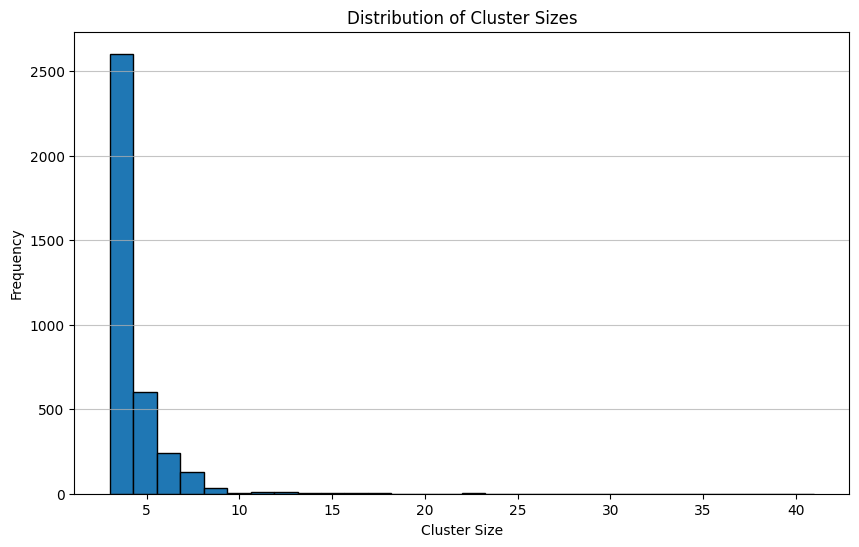

<Figure size 640x480 with 0 Axes>

In [ ]:
# 4. Visualize cluster sizes
import matplotlib.pyplot as plt

cluster_sizes = [len(comp) for comp in connected_components if len(comp) > 2]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(cluster_sizes, bins=30, edgecolor='black')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.title('Distribution of Cluster Sizes')
plt.grid(axis='y', alpha=0.75)
plt.show()
# Save the figure
plt.savefig("cluster_sizes_distribution.png")
